# Loan payment prediction.
In this notebook, we will use the prepared data from 'Loan_payment_feature_engineering.ipynb' to see whether we can predict whether a running loan will run into payment problems.  
We will make the following choices:
- The finished loans will be used as both training and testing data. As we have full knowledge on their runtime, they are nice examples to test whether a loan will get problems or not.  
- We use the 75/25 split from the 'Loan_payment_feature_engineering.ipynb' notebook.
- We will only predict whether a running will have payment problems in the future. We will make some assumptions to make a first prediction somewhat simpler.
    - 'All running loans are equal': Even though we may use the past payment missis a feature in our prediction, all loans will receive a prediction on future loans. Also, we assume that all running loans will continue to run (hence take no weight/factor into account for loans with a shorter/longer running time. This as future missed payments may still hurt the bank.
    - 'We only predict whether problems will occur': We start with a simple classifier which will output either yes or no and make no predicition on when the problems may occur.
    - 'We take no seasonality into account': In our first model, all years are equal and thus all loans are equal. This will make testing our hypothesis easier.
- We will compare several models to see if and how easy they can provide a good prediction.

#### Import numpy, pandas and the dataset.
- Load
- Split the 'status' in two columns: finished and past_debt
- Drop the loan_id, account_id, client_id, district_id and status columns
- Set start_date as date and convert it to the year.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/loan_prep.csv')

df.loc[df['status']=='run_no_problem', 'finished'] = 0
df.loc[df['status']=='run_but_debt', 'finished'] = 0
df.loc[df['status']=='fin_no_problem', 'finished'] = 1
df.loc[df['status']=='fin_unpaid', 'finished'] = 1

df.loc[df['status']=='run_no_problem', 'past_debt'] = 0
df.loc[df['status']=='run_but_debt', 'past_debt'] = 1
df.loc[df['status']=='fin_no_problem', 'past_debt'] = 0
df.loc[df['status']=='fin_unpaid', 'past_debt'] = 1

del df['status']
del df['loan_id']
del df['account_id']
del df['client_id']
del df['district_id_client']
del df['district_id']

df['start_year'] = pd.to_datetime(df['start_date'], 
                                  format='%Y-%m-%d').dt.year

#### Basis statistics:
I just decide to look at the basic statistics we always look at. Such as the shape, a description and skewedness.

In [3]:
print('shape:')
print(df.shape)
print('\ndescription:')
print(df.describe())
print('\nskwenedness:')
print(df.skew())

shape:
(682, 27)

description:
              amount    duration     payments  total_missed  first_quarter  \
count     682.000000  682.000000   682.000000    682.000000     682.000000   
mean   151410.175953   36.492669  4190.664223      0.535191       0.249267   
std    113372.406310   17.075219  2215.830344      1.993254       1.064460   
min      4980.000000   12.000000   304.000000      0.000000       0.000000   
25%     66732.000000   24.000000  2477.000000      0.000000       0.000000   
50%    116928.000000   36.000000  3934.000000      0.000000       0.000000   
75%    210654.000000   48.000000  5813.500000      0.000000       0.000000   
max    590820.000000   60.000000  9910.000000     18.000000      11.000000   

       second_quarter  third_quarter  last_quarter  max_missed       balance  \
count      682.000000     682.000000    682.000000  682.000000    682.000000   
mean         0.105572       0.112903      0.067449    0.340176  44023.518001   
std          0.581656     

## Initial Visualization.
Box en densityplots for continuous variables, bar chart for ordinal/categorical variables. These are selected manually as it is easier and faster than setting some thresholds.  
On the density plots we can immediatly compare those in debt and those not in debt.

In [4]:
continuous_vars = ['amount', 'payments',
                'balance','birthyear_owner',
                'startyear_client','average_volume',
                'average_volume_cash', 'average_volume_cc',
                'inhabitants', 'urban_ratio',
                'avg_unemployment', 'avg_committed_crimes',
                'total_number_trans', 'total_number_cash',
                'start_year','total_number_cc']

categorical_vars = ['duration','total_missed',
                    'first_quarter', 'second_quarter', 
                    'third_quarter', 'last_quarter',
                    'max_missed','female',
                    'finished','past_debt']
print(len(continuous_vars))
print(len(categorical_vars))

16
10


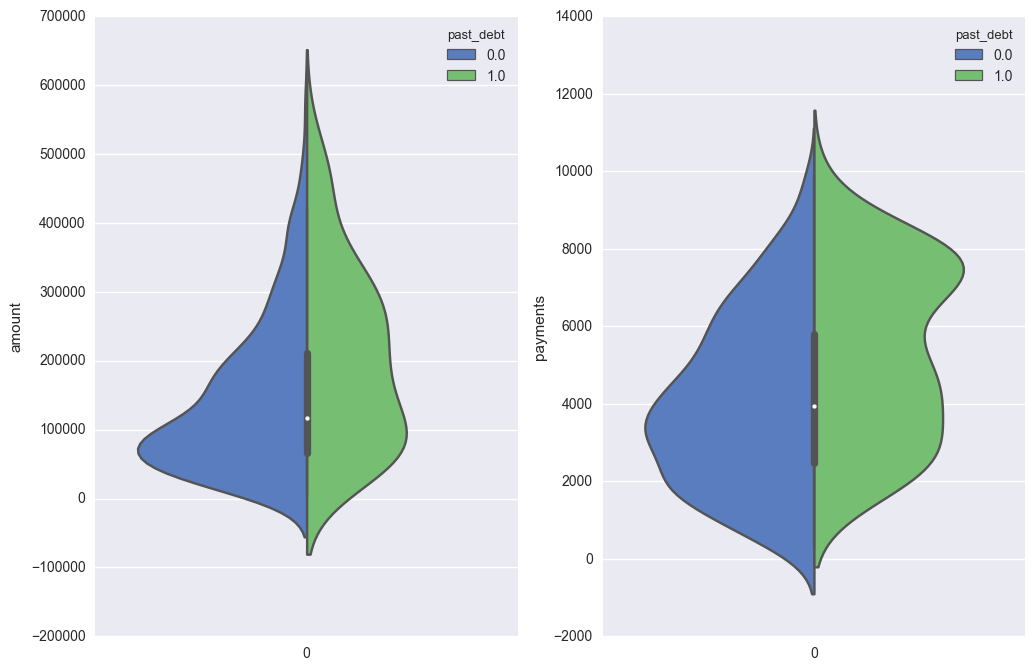

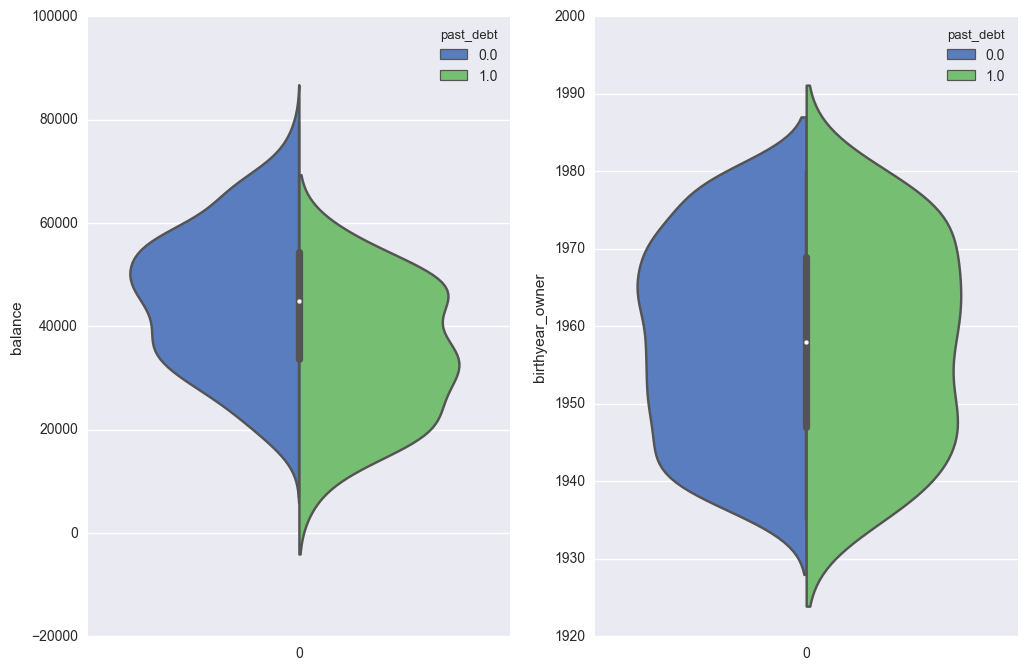

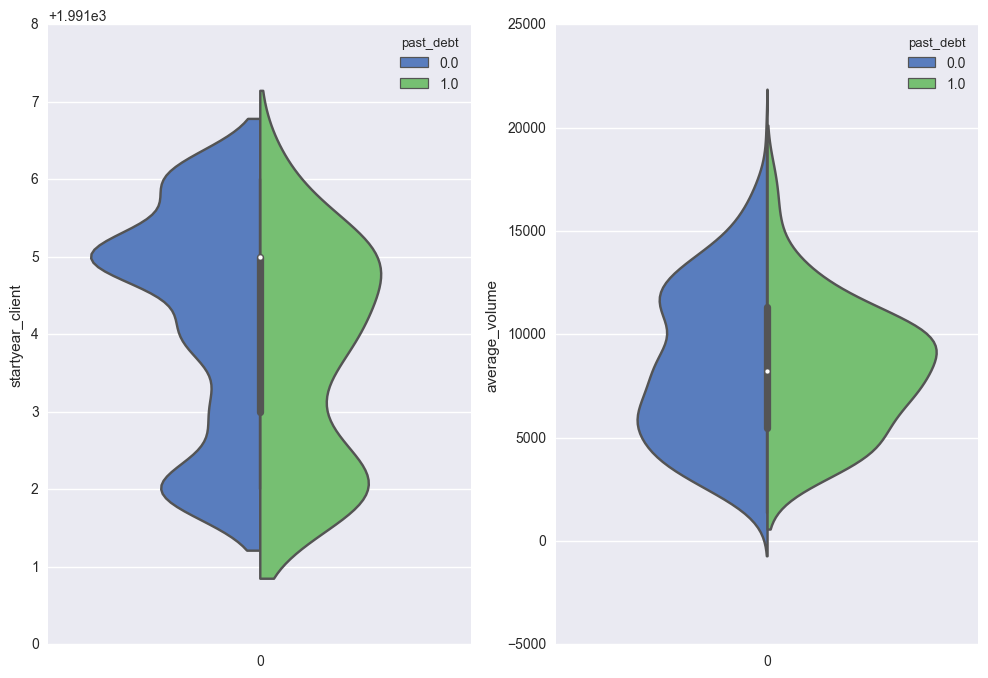

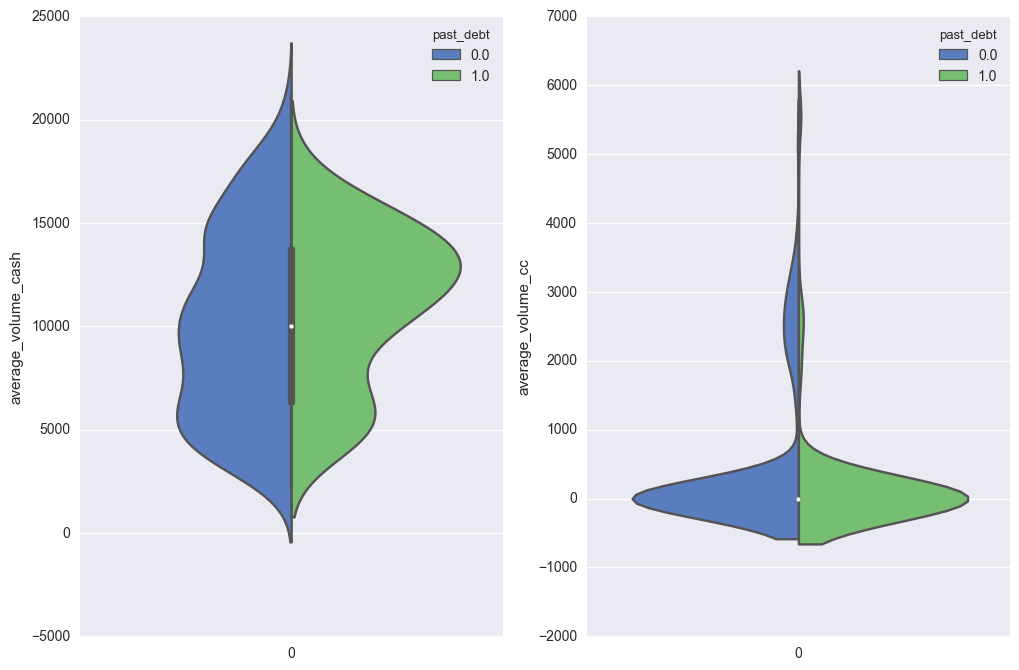

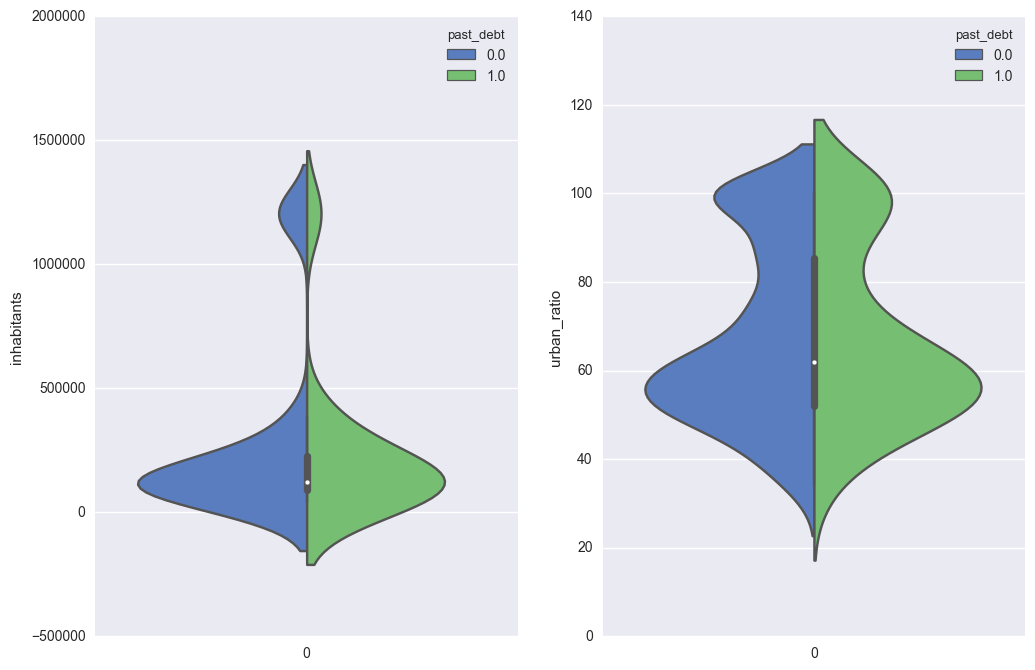

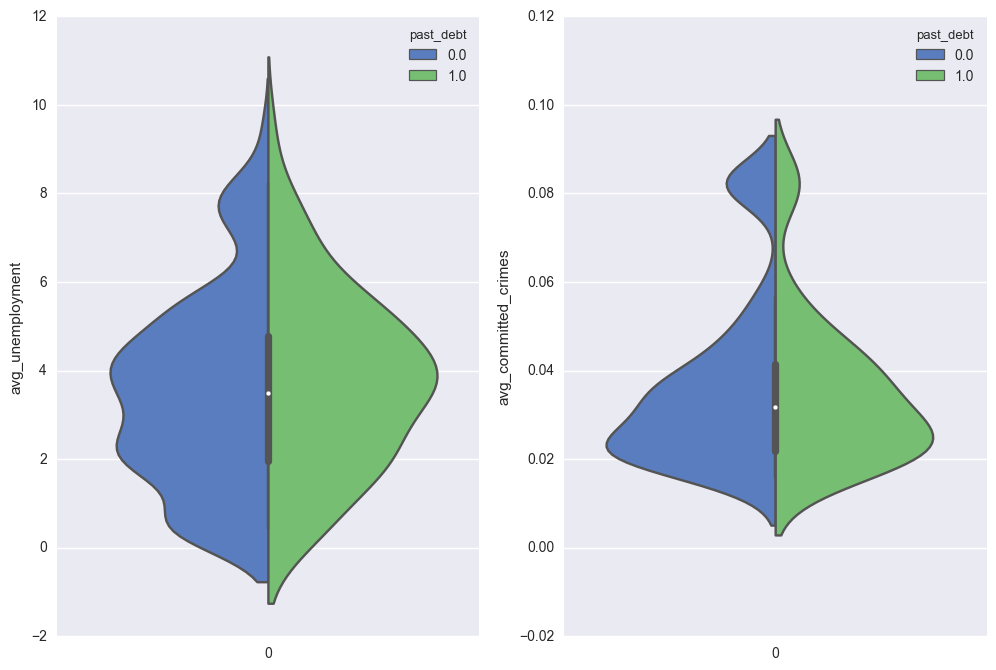

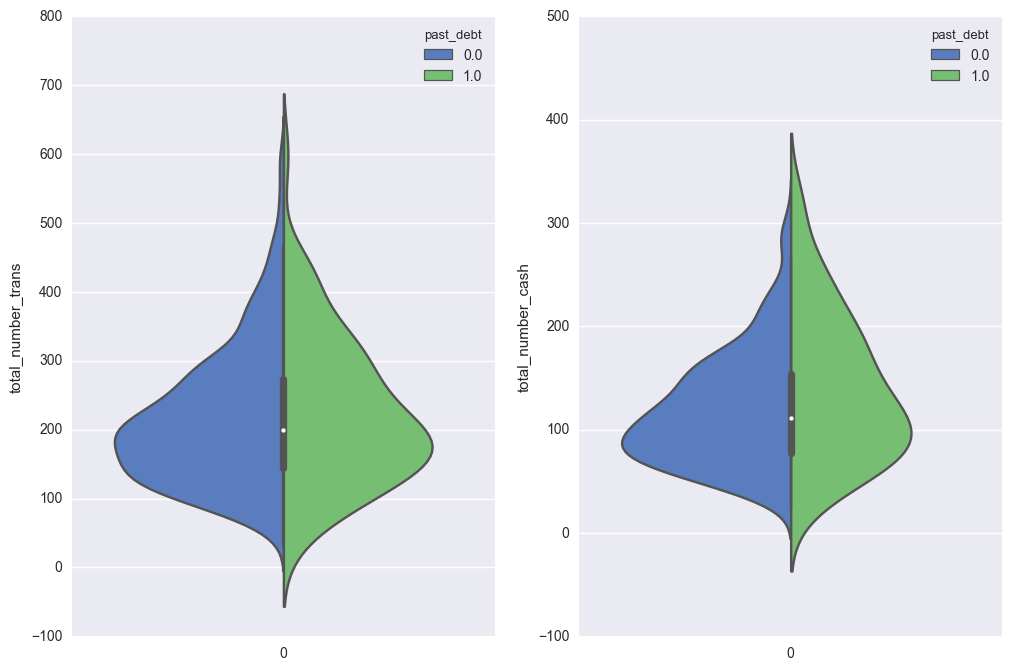

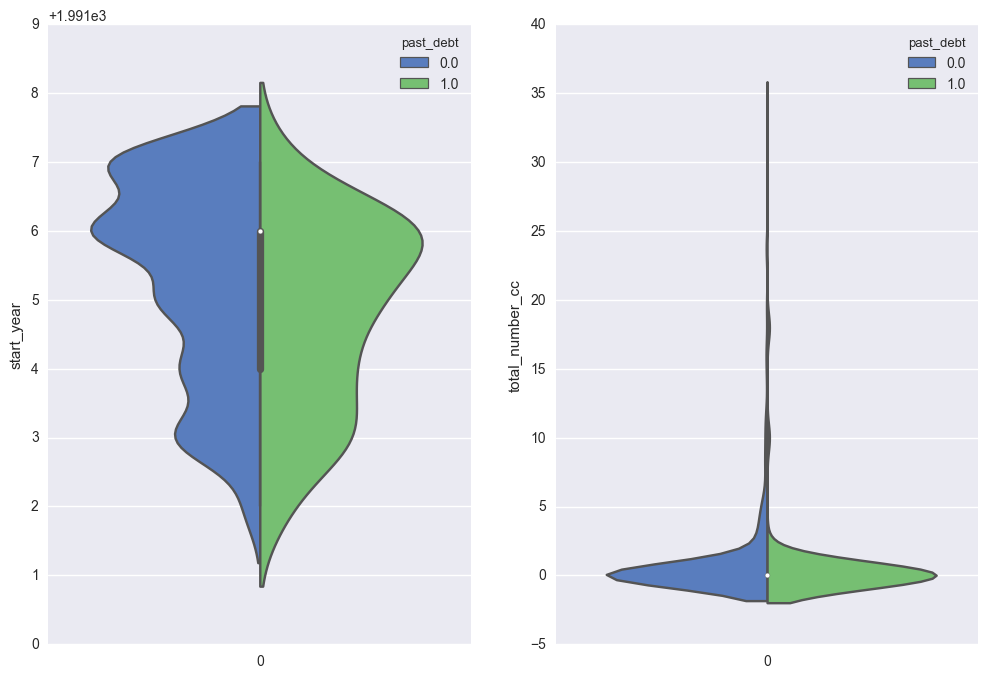

In [5]:
df_cont = df.loc[:,continuous_vars].copy()
df_cont['past_debt'] = df['past_debt'].astype(str)
df_cont[' '] = 0
cols = df_cont.columns
n_cols = 2
n_rows = 8
for i in range(n_rows):
    fg, ax = plt.subplots(nrows = 1, ncols = n_cols, figsize = (12, 8))
    for j in range(n_cols):
        sns.violinplot(x = ' ',
                       y = cols[i*n_cols+j], 
                       data = df_cont, 
                       hue = 'past_debt',
                       ax = ax[j],
                       palette='muted',
                       split = True)

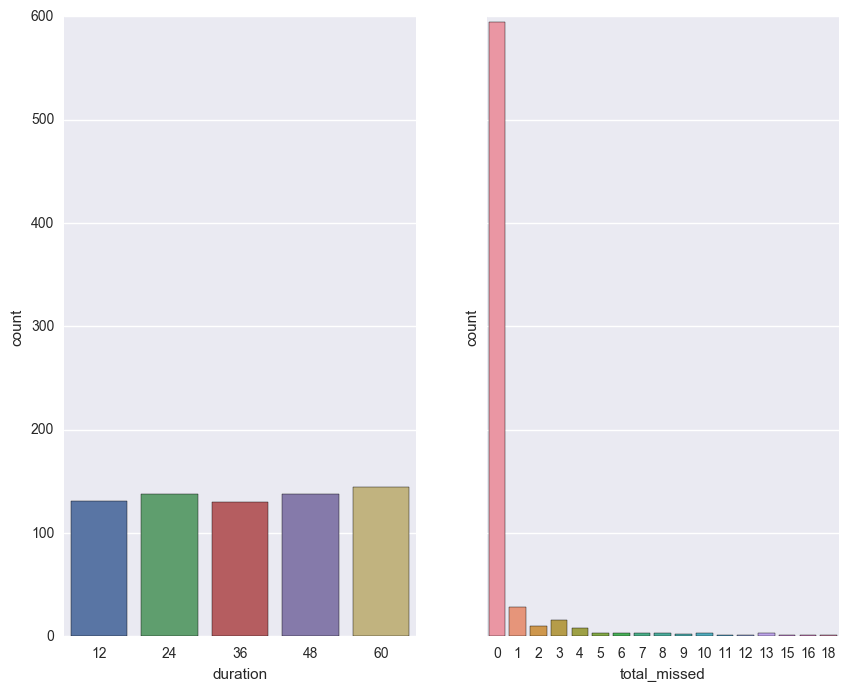

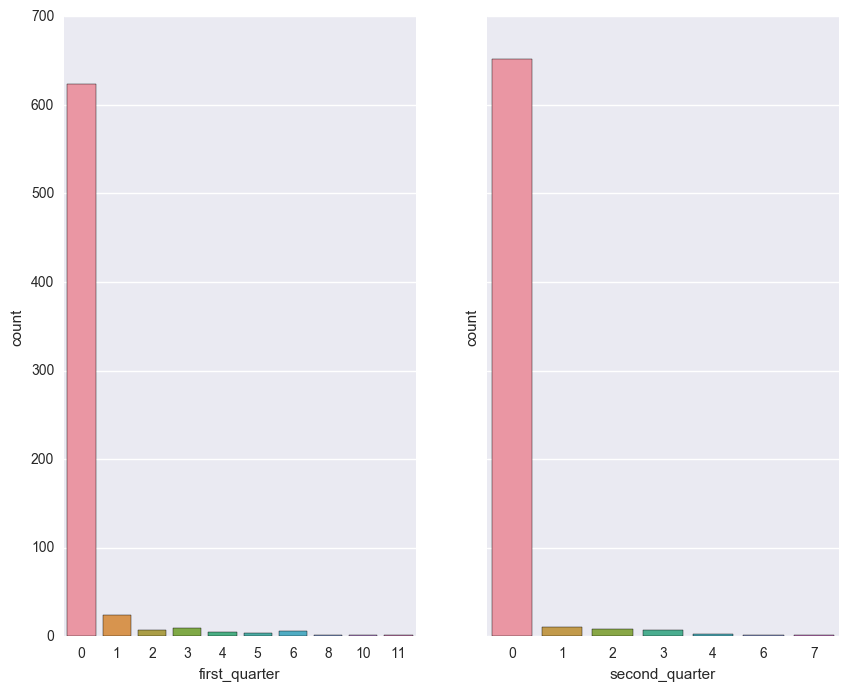

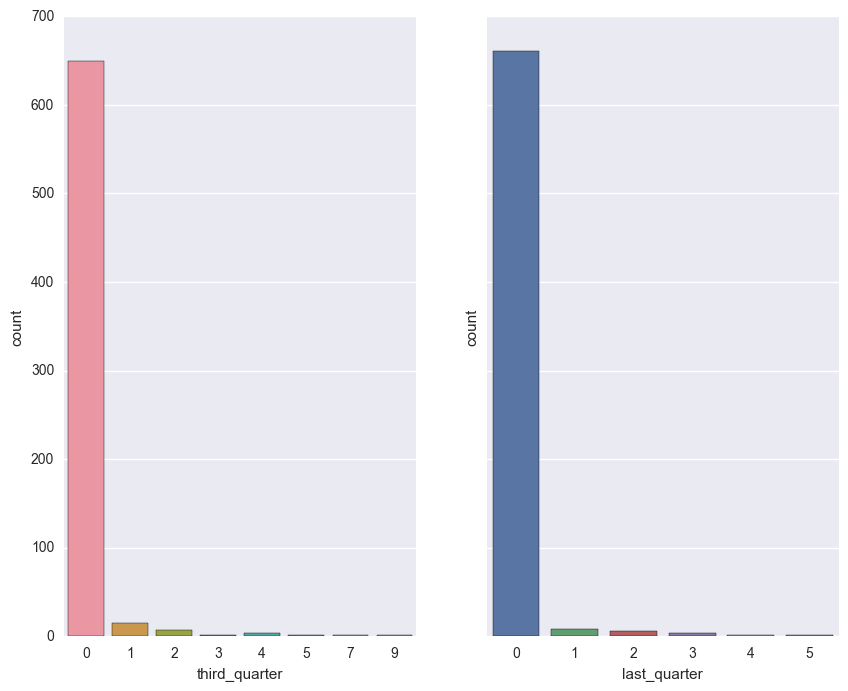

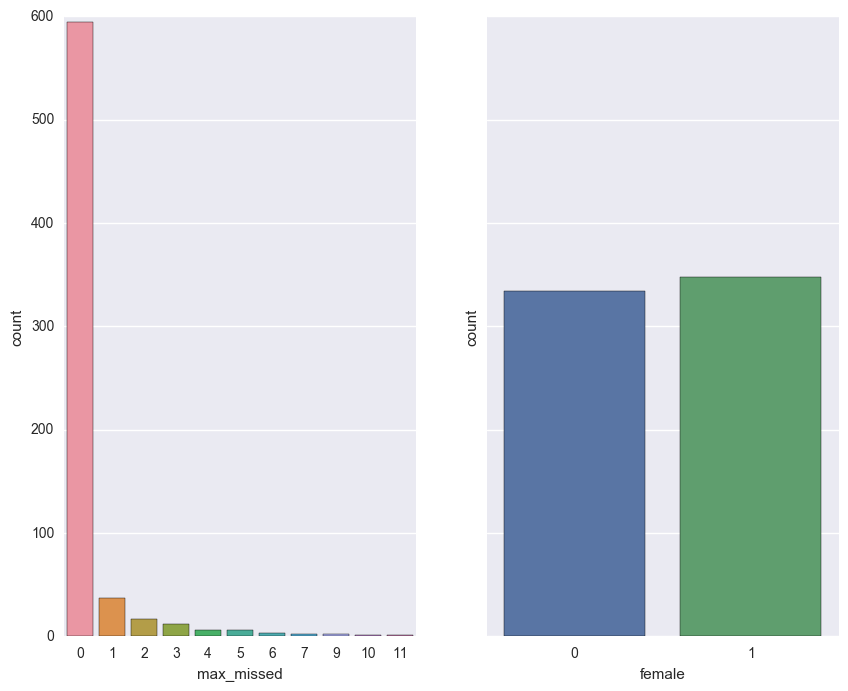

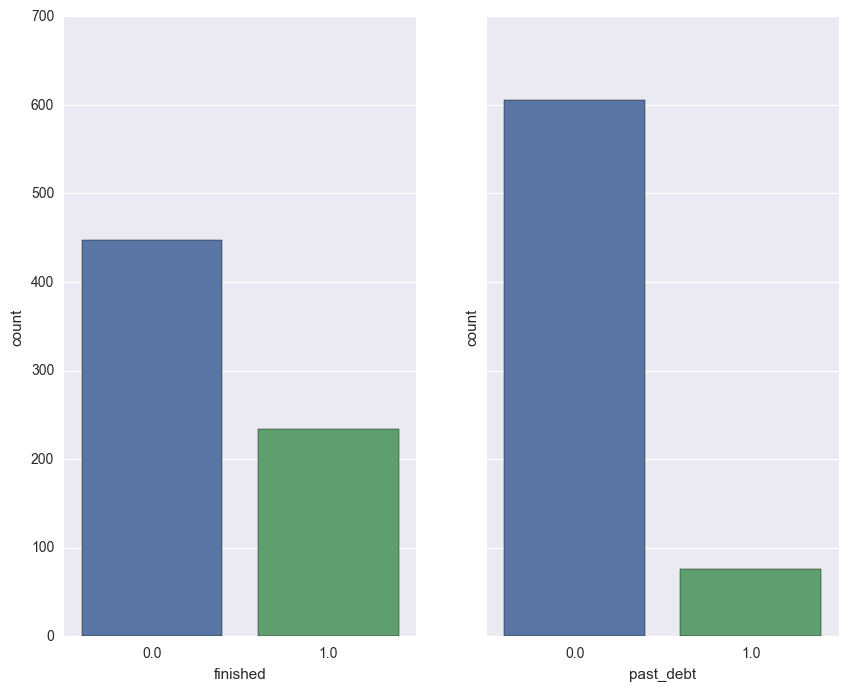

In [6]:
df_cat = df.loc[:,categorical_vars]
cols = df_cat.columns
n_cols = 2
n_rows = 5
for i in range(n_rows):
    fg, ax = plt.subplots(nrows = 1, ncols = n_cols,
                          sharey = True, figsize = (10, 8))
    for j in range(n_cols):
        sns.countplot(x = cols[i*n_cols+j], data = df_cat, ax = ax[j])


#### First impressions
- We only have a small part of clients in debt.
- Clients in debt seem to have higher monthly paymets but less balance on the bank.
- They seem to move more cash than the other clients.
- Also, they seem to have a higher average volume of transactions.
- We don't see many demographic differences (as stated in the previous notebook, these are region averages)

## Correlation
Correlation can be important when estimating models. A quick plot to show us which columns are correlated:
Using: https://github.com/louridas/corrplot/blob/master/corrplot.py (with my addition of adjusting the figure size)

<module 'matplotlib.pyplot' from '/Users/moeben001/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

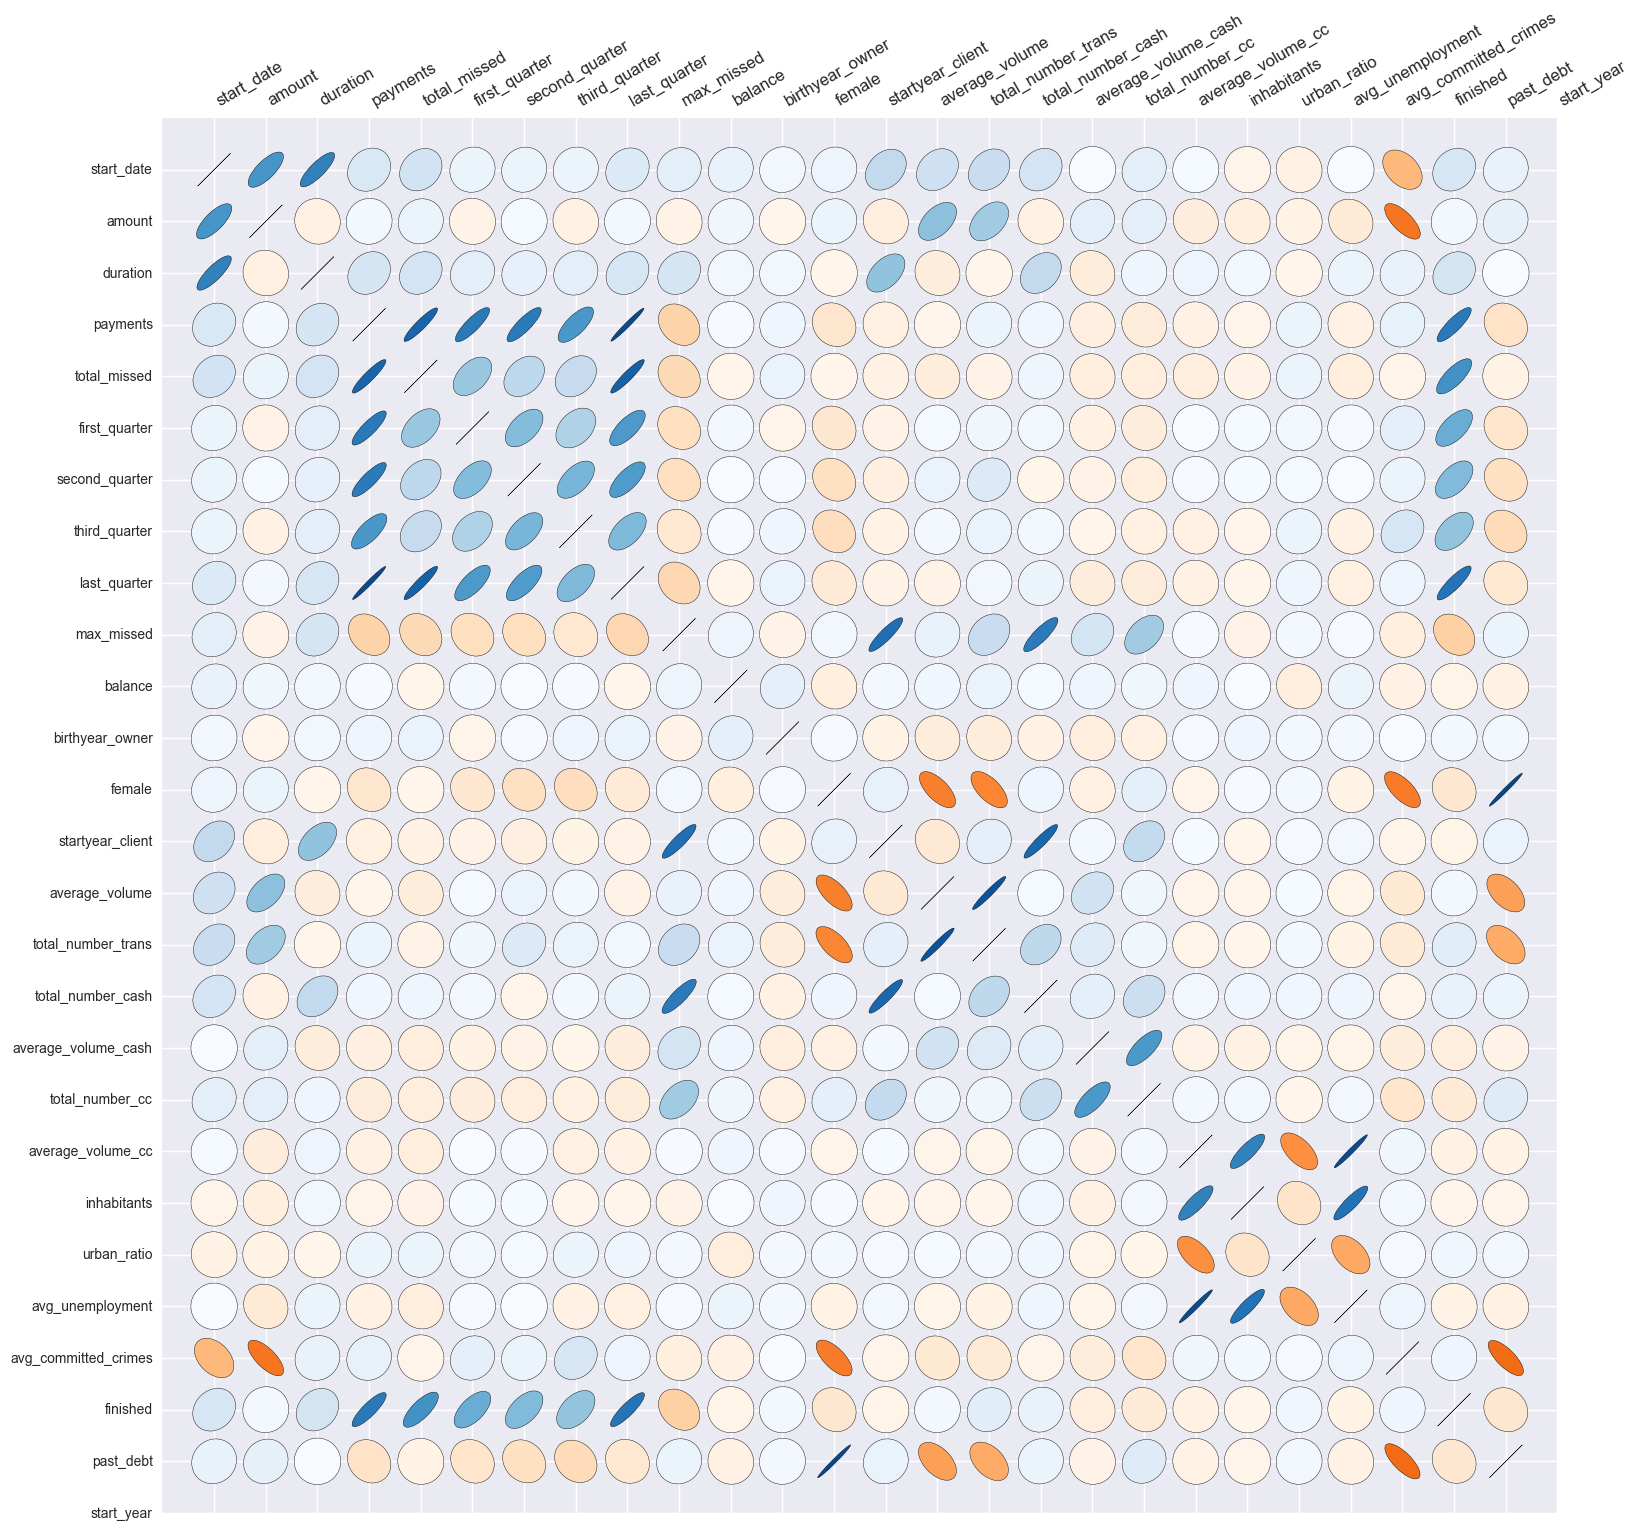

In [7]:
import corrplot as crplt
corr = df.corr()
corr = corr.as_matrix()
pvalues = np.zeros((26,26))
names = np.asarray(df.columns)

crplt.corrplot(corr, pvalues, names, figsize = (18,18))

#### First impressions
We can see some blocks of correlation. The first one to catch our eye is the missed columns. These have high correlation as all our correctly paying customers have 0 value here. Moreover, we see that customers who have had their account longer have a higher total number and volume of transactions and cash. Hence it may be better to use the average volume of transactions.  
Also we see that finished loans have an earlier start date, and belong to earlier clients. Moreover, we see that the demographic data is correlated, this is possibly due to the fact that they are merged into the data from a relatively small dataset.

## Setting the stage
We have almost reached the climax of our exercise. All that is left is to determine the usual parameters:
- What will be the metric to which we test?
- How will we define our training and test sets?
- Which models will we use?

To tackle the first, remember that we want to predict future debt using past debt. Our data is highly skewed however, as we have 606 accounts without any debt and only 76 with debt. Hence, using our accuracy score may not be the best choice. We will go with the F1 score as it will provide us with a nice balance between precision, recall and accuracy.  
Now actually configuring the data to do what we want is quite difficult. As we want to predict 'future missed payments' we need to use data in which we can predict future payments (as our past_debt only shows us if there is any past debt). We do however have the missed counts in all the quarters which we can use. Thus the setup will be as follows:
1. Use the finished data as training set
2. Use the finshed data as test set.
3. For both these datasets, use the first 3 quarters as prediction for msised payment in the last. 
4. Use a few running tests as vaildation.
5. Finish with predictions on the full running dataset.

As for the models, we will use the usual suspects:
- Naive Bayes
- SVM
- Logistic regression
- Decision Tree
- Bagging
- AdaBoost
- Random Forest

#### Subsetting on finished data

In [8]:
# Split finisahed and running data
df_fin = df[df['finished']==1].copy()
df_run = df[df['finished']!=1].copy()

Now for all finished loans, we transform total_missed into total_missed_3 to be over the first three quarters and transform last_quarter to missed_payment, a 0-1 vector which will be our target variable

In [9]:
df_fin['total_missed_3'] = df_fin['first_quarter'] + df_fin['second_quarter'] + df_fin['third_quarter']
df_fin['missed_payment'] = 0
df_fin.loc[df_fin.last_quarter > 0, 'missed_payment'] = 1

#### Setting up the model.
As we have a low number of missed payments in our dataset (18 out of 243) we will use a training and testing set (ensuring both contain some of the missed payments) in a 80/20 ratio.  
We start with selecting the possibly usefull parameters.

In [10]:
features = ['amount', 'duration', 'payments', 'balance', 
                   'birthyear_owner', 'female', 'startyear_client',
                   'average_volume', 'average_volume_cash', 'total_missed_3',
                   'max_missed']
target = ['missed_payment']
full = df_fin[features + target]
features = df_fin[features]
target = df_fin[target]

Then we remake our correlation plot

<module 'matplotlib.pyplot' from '/Users/moeben001/anaconda2/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

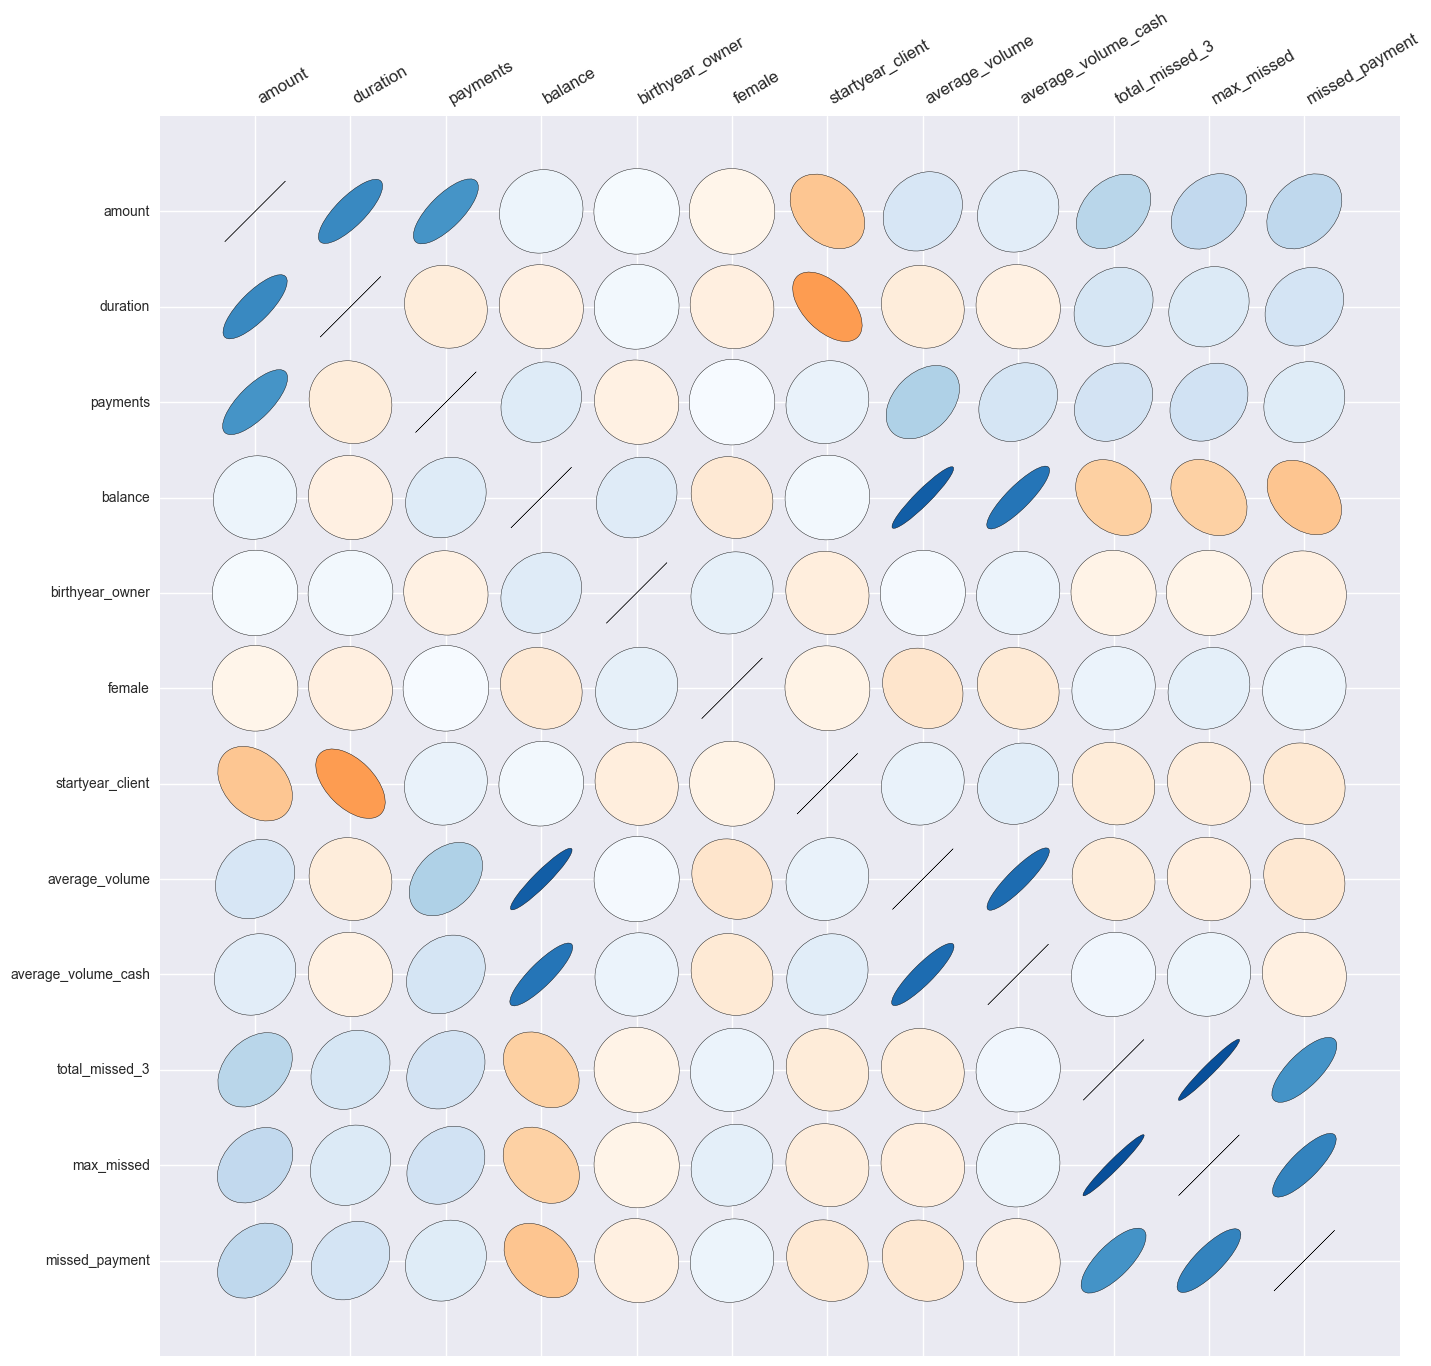

In [11]:
corr = full.corr()
corr = corr.as_matrix()
pvalues = np.zeros((12,12))
names = np.asarray(full.columns)

crplt.corrplot(corr, pvalues, names, figsize = (16,16))

This shows that (max) missed payments in the past can be a very good predictor for misses in the future. Hence, using these parameters seems reasonable. However, as many of our running or new clients will not have this data, we will remove them.  
Moreover, average volume, balance and average cash volume seem highly correlated.
Looking at our missed_payment indicataor, we will use balance in our features.

In [12]:
features = ['amount', 'duration', 'payments', 'balance', 
            'birthyear_owner', 'female', 'startyear_client']
target = ['missed_payment']
full = df_fin[features + target]
features = df_fin[features]
target = df_fin[target]

Transform it into the usual format

In [13]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    target, 
                                                    test_size = 0.2, 
                                                    random_state = 500)
print(y_test['missed_payment'].value_counts())
print(y_train['missed_payment'].value_counts())

y_test = y_test.ix[:,0].tolist()


0    43
1     4
Name: missed_payment, dtype: int64
0    173
1     14
Name: missed_payment, dtype: int64


/Users/moeben001/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


We will estimate every model using grid search where possible over the full grid of possible parameters. As we will not use cross validation we build our version. Also, we want to select certain features at random, to see if there may be improvement in selecting more/less featuers.

In [14]:
def gridSearch(estimator ,grid, X_train, y_train, X_test, y_test, random_size = None):
    from sklearn.model_selection import ParameterGrid
    from sklearn.metrics import f1_score
    import pprint 
    if random_size:
        sizes = np.random.choice(np.arange(1, X_train.shape[1]), 
                                 random_size).tolist()
    else:
        sizes = [1]
    output = {}
    best_score = 0.0
    ticker = 0
    col_names = list(X_train)
    for size in sizes:
        select = np.random.choice(list(X_train), size, replace = False).tolist()
        X_train_slct = X_train[select]
        X_test_slct = X_test[select]
        for g in ParameterGrid(grid):
            ticker = ticker + 1
            clf = estimator
            clf.set_params(**g)
            clf.fit(X_train_slct, y_train)
            pred = clf.predict(X_test_slct)
            score = f1_score(y_test, pred)
            acc_score = clf.score(X_test_slct, y_test)
            output['run_' + str(ticker)] = {'columns': list(X_train_slct),
                        'params' : g,
                        'pred': pred, 
                        'score': score,
                        'acc': acc_score}
    return(output)

### Expectations
I expect the normal classifiers to behave badly on this data. This is primarily due the low amount of hits in our data. Boosting/bagging or random forests should perfom better.

### Naive Bayes
As we have no priors, we do not have to use the above function. Hence, we use the normal setup to test.

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score
clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print "f1_score:"
print f1_score(y_test, pred)
print "accuracy:"
print clf.score(X_test, y_test)

f1_score:
0.444444444444
accuracy:
0.893617021277


/Users/moeben001/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


We see indeed that naive bayes is not able to predict the 1's in our data with the given features.

### SVM
In the SVM, we also try balancing the classes to see if we get better results than with Naive Bayes.

In [16]:
from sklearn import svm
grid = {'kernel':('linear', 'rbf'), 'C':[1, 10], 'class_weight': (None, 'balanced')}
svm_output = gridSearch(svm.SVC(), grid , X_train, y_train, X_test, y_test, 5)

/Users/moeben001/anaconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


The SVM also seems to struggle with the low amount of correct predictions for 1. Some values which score more than 0 are:

In [17]:
for key, value in svm_output.iteritems():
    if value['score'] > 0.4:
        print value['params']
        print value['columns']
        print value['score']
        print "\n"

{'kernel': 'linear', 'C': 10, 'class_weight': 'balanced'}
['amount', 'payments', 'female', 'startyear_client', 'birthyear_owner', 'balance']
0.428571428571


{'kernel': 'rbf', 'C': 1, 'class_weight': 'balanced'}
['duration', 'amount', 'payments', 'startyear_client', 'female']
0.666666666667


{'kernel': 'rbf', 'C': 10, 'class_weight': 'balanced'}
['duration', 'amount', 'payments', 'startyear_client', 'female']
0.666666666667


{'kernel': 'rbf', 'C': 10, 'class_weight': None}
['duration', 'amount', 'payments', 'startyear_client', 'female']
0.666666666667


{'kernel': 'linear', 'C': 1, 'class_weight': 'balanced'}
['amount', 'payments', 'female', 'startyear_client', 'birthyear_owner', 'balance']
0.428571428571




These scores are however not yet high enough. (maximum is f1 score of 0.5)

### Logistic regression
For logistic regression we pick a similar setup as for the SVM, hoping to get better results.

In [18]:
from sklearn.linear_model import LogisticRegression
grid = {'penalty' : ('l1', 'l2'), 'C':[1,10], 'class_weight': (None, 'balanced')}
logreg_output = gridSearch(LogisticRegression(), grid, X_train, y_train, X_test, y_test, 5)

In [19]:
for key, value in logreg_output.iteritems():
    if value['score'] > 0.4:
        print value['params']
        print value['columns']
        print value['score']
        print "\n"

Here, we see the same as for SVM, results not getting an f1 score higher than 0.5

### Decision Tree

In [20]:
from sklearn.tree import DecisionTreeClassifier
grid = {'max_features':[0.25,0.5,0.75], 'max_depth': [1,2,3]}
tree_output = gridSearch(DecisionTreeClassifier(), grid, X_train, y_train, X_test, y_test, 5)

In [21]:
for key, value in tree_output.iteritems():
    if value['score'] > 0.4:
        print value['params']
        print value['columns']
        print value['score']
        print "\n"

### Bagging


In [22]:
from sklearn.ensemble import BaggingClassifier
cart = DecisionTreeClassifier()
n_trees = 1000
clf = BaggingClassifier(base_estimator = cart, 
                        n_estimators = n_trees)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = f1_score(y_test, pred)
acc_score = clf.score(X_test, y_test)
print score
print acc_score

0.4
0.936170212766


### AdaBoost


In [23]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators = 1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = f1_score(y_test, pred)
acc_score = clf.score(X_test, y_test)
print(score)
print(acc_score)

0.5
0.914893617021


### Random Forest

In [24]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators = 1000)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
score = f1_score(y_test, pred)
acc_score = clf.score(X_test, y_test)
print(score)
print(acc_score)

/Users/moeben001/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  app.launch_new_instance()


0.4
0.936170212766


### Final model
Train on finished data:

In [25]:
param = {'kernel': 'rbf', 'C': 1, 'class_weight': 'balanced'}
clf = svm.SVC()
clf.set_params(**param)
clf.fit(X_train[['startyear_client', 'duration', 'payments']], y_train)

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Prep running data:

In [26]:
df_run['total_missed_3'] = df_run['first_quarter'] + df_run['second_quarter'] + df_run['third_quarter']
df_run['missed_payment'] = 0
df_run.loc[df_run.last_quarter > 0, 'missed_payment'] = 1
features = ['amount', 'duration', 'payments', 'balance', 
            'birthyear_owner', 'female', 'startyear_client']
target = ['missed_payment']
full = df_run[features + target]
features = df_run[features]
target = df_run[target]

Predict future payment problems:

In [27]:
df_run['future_problem'] = clf.predict(features[['startyear_client', 'duration', 'payments']])

Plot past payment trouble with future trouble:

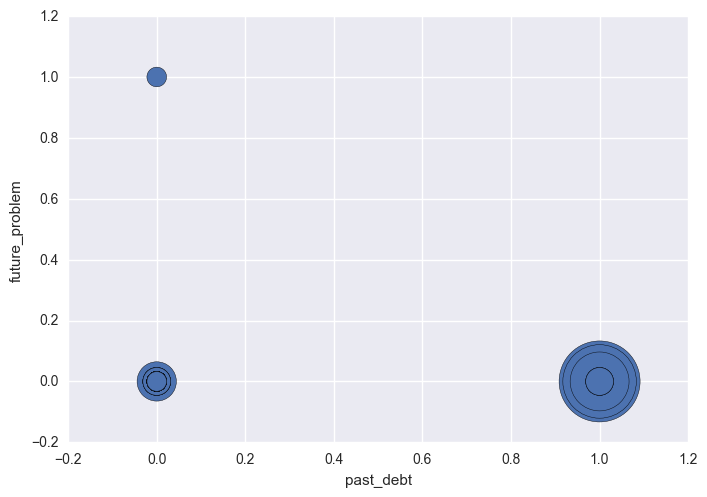

In [28]:
df_run.plot.scatter(x = 'past_debt', 
                    y ='future_problem', 
                    s = 200 *(df_run['total_missed'] +1) )